In [129]:
import wandb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import importlib
from common import common
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.datasets import fetch_covtype

In [130]:
wandb.login()

True

In [131]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/bytedance/Downloads/work/CS5344_Project/work/common/common.py'>

In [132]:
# Function to evaluate and print model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    seconds = time.time()
    # Train the model
    model.fit(X_train, y_train)
    print("Train operation time: = ",time.time()- seconds ,"seconds")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Print model evaluation metrics
    common.evaluate(y_test, y_pred, f"\nModel: {model.__class__.__name__}")

In [133]:
# Dictionary to store models and their names
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine (SVM)": SVC()
}

In [134]:
# project name should correspond to dataset below
# project_name = "covertype"
# project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
# project_name = "unsw"
# project_name = "customer"
# project_name = "satellite"
# project_name = "drug"
project_name = "mba"

In [135]:
if project_name == "covertype":
    %run datasets/covertype.ipynb
    all_df, main_labels, config = get_processed_covtype_df()
elif project_name == "kdd":
    %run datasets/kdd.ipynb
    all_df, main_labels, config = get_processed_kdd_df()
elif project_name == "cicids":
    %run datasets/cicids.ipynb
    all_df, main_labels, config = get_processed_cicids_df()
elif project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "unsw":
    %run datasets/unsw.ipynb
    all_df, main_labels, config = get_processed_unsw_df()
elif project_name == "customer":
    %run datasets/customer.ipynb
    all_df, main_labels, config = get_processed_customer_df()
elif project_name == "satellite":
    %run datasets/satellite.ipynb
    all_df, main_labels, config = get_processed_satellite_df()
elif project_name == "drug":
    %run datasets/drug.ipynb
    all_df, main_labels, config = get_processed_drug_df()
else:
    %run datasets/mba.ipynb
    all_df, main_labels, config = get_processed_mba_df()

Normal class:  0    Admit
Name: admission, dtype: object
TARGET_DICT {0: 'Admit', 1: 'Deny', 2: 'Waitlist'}
NORMAL_TARGET 1
main_labels ['gender', 'international', 'gpa', 'major', 'race', 'gmat', 'work_exp', 'work_industry', 'admission']
Normal class:  0    Admit
Name: admission, dtype: object
TARGET_DICT {0: 'Admit', 1: 'Deny', 2: 'Waitlist'}
NORMAL_TARGET 1
main_labels ['gender', 'international', 'gpa', 'major', 'race', 'gmat', 'work_exp', 'work_industry', 'admission']


In [136]:
# Should already be one hot encoded and label encoded

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,0,0,3.30,0,0,620.0,3.0,3,0
1,1,0,3.28,1,1,680.0,5.0,6,1
2,0,1,3.30,0,4,710.0,5.0,13,0
3,1,0,3.47,2,1,690.0,6.0,13,1
4,1,0,3.35,2,2,590.0,5.0,1,1


In [137]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and testing sets (80% train, 20% test)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(4955, 8) (1239, 8) (4955,) (1239,)


In [138]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

Train operation time: =  0.02220606803894043 seconds

Model: LogisticRegression


/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

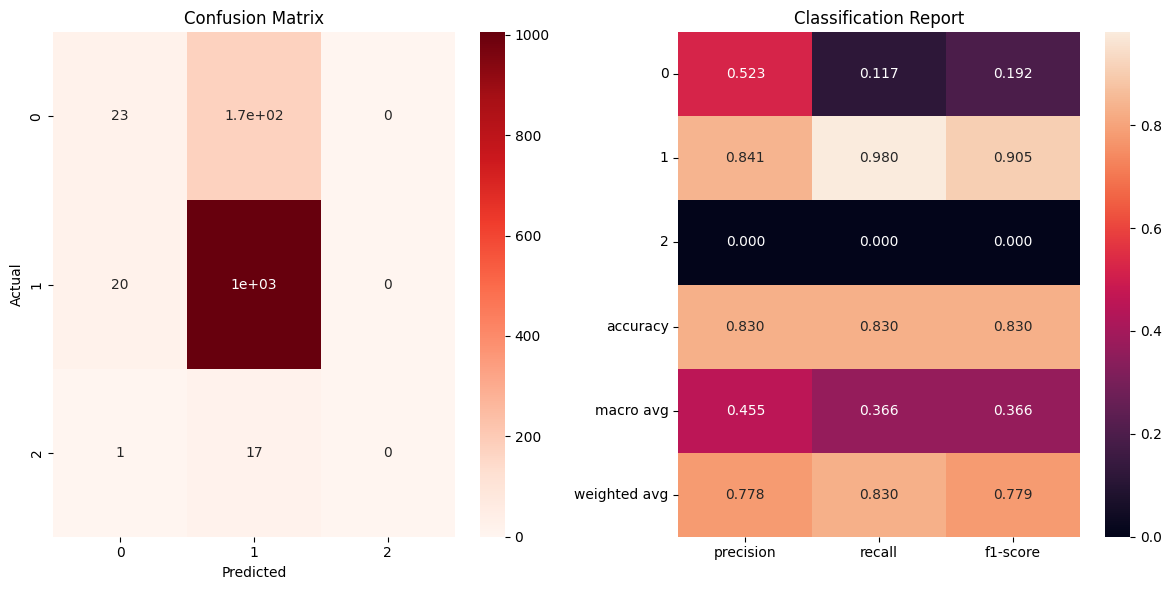

Accuracy: 0.8297013720742534


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.8297
f1-score_avg,0.77934
precision_avg,0.77844
recall_avg,0.8297


Train operation time: =  0.006930351257324219 seconds

Model: DecisionTreeClassifier


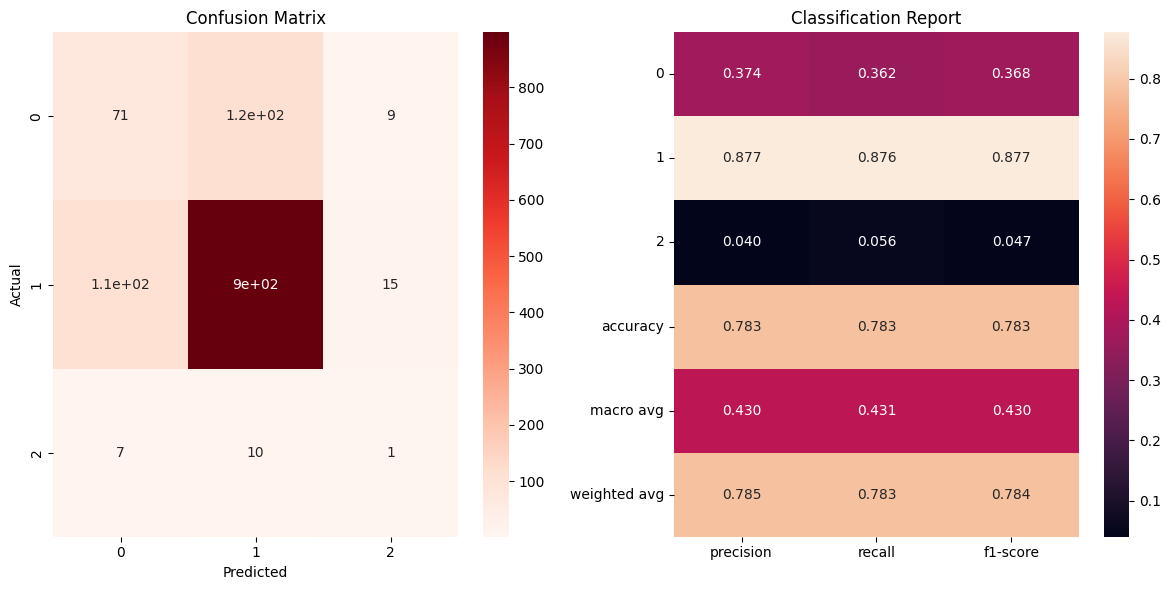

Accuracy: 0.7828894269572235


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.78289
f1-score_avg,0.784
precision_avg,0.78518
recall_avg,0.78289


Train operation time: =  0.23349571228027344 seconds

Model: RandomForestClassifier


/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

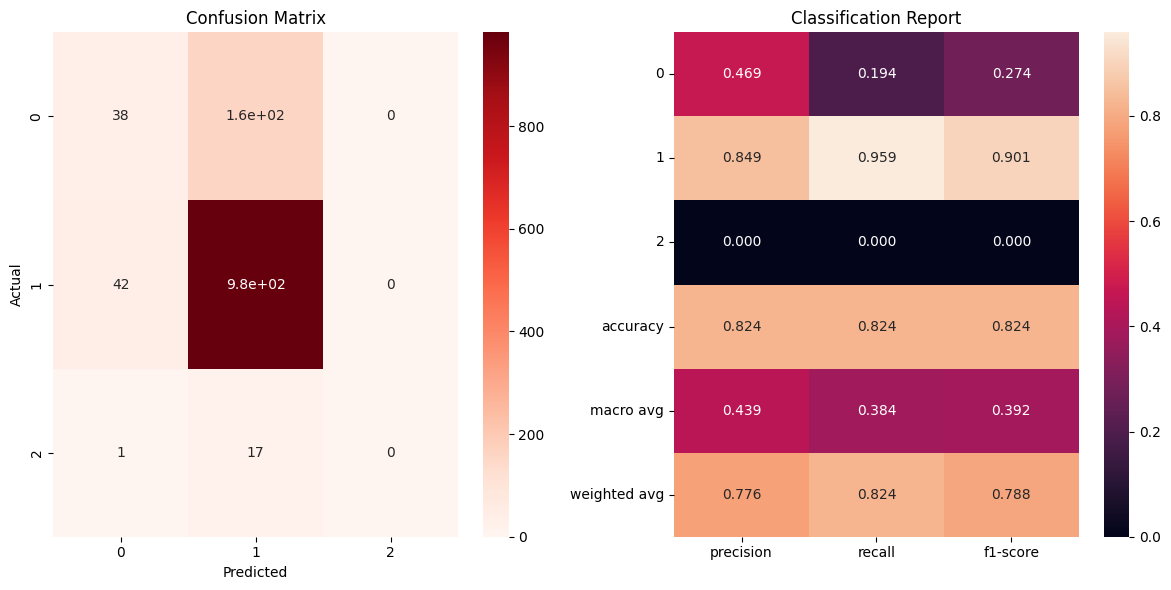

Accuracy: 0.8240516545601292


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.82405
f1-score_avg,0.78845
precision_avg,0.77647
recall_avg,0.82405


Train operation time: =  0.7265987396240234 seconds

Model: GradientBoostingClassifier


/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

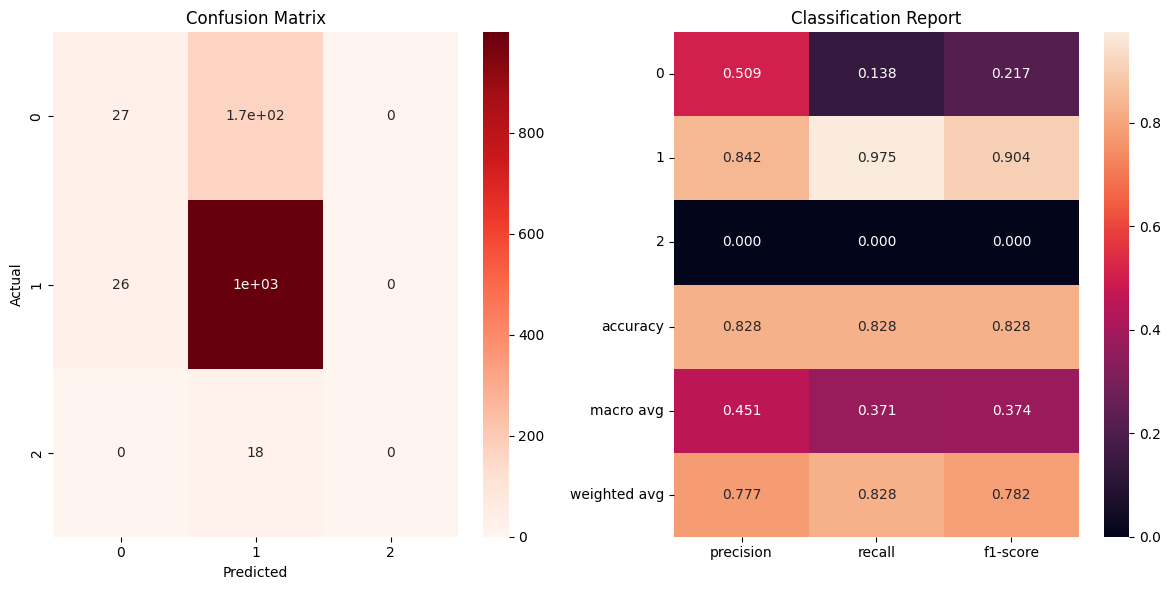

Accuracy: 0.8280871670702179


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.82809
f1-score_avg,0.78189
precision_avg,0.77743
recall_avg,0.82809


Train operation time: =  0.0024471282958984375 seconds

Model: KNeighborsClassifier


/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

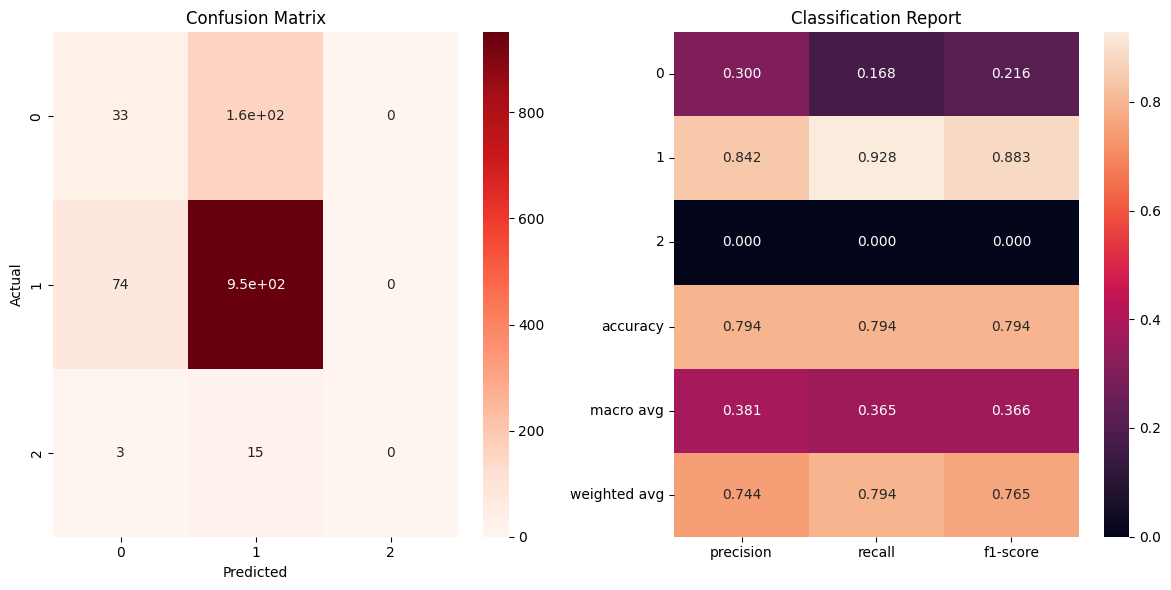

Accuracy: 0.7941888619854721


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.79419
f1-score_avg,0.76462
precision_avg,0.74431
recall_avg,0.79419


Train operation time: =  0.3572196960449219 seconds

Model: SVC


/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bytedance/Downloads/work/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

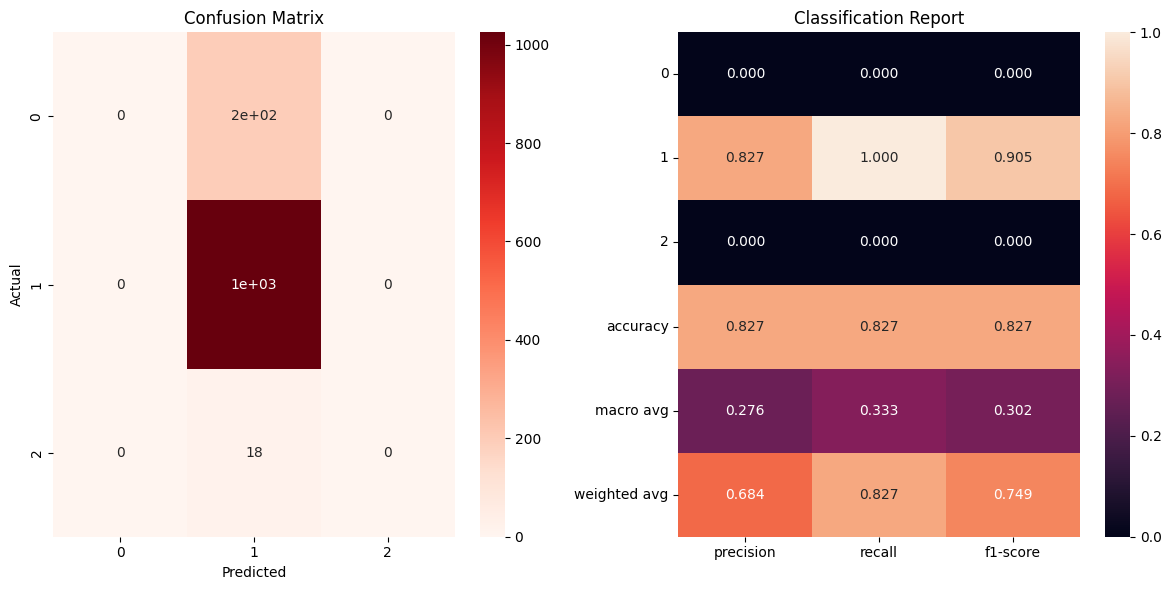

Accuracy: 0.8272800645682001


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.82728
f1-score_avg,0.74908
precision_avg,0.68439
recall_avg,0.82728


Total operation time: =  50.797788858413696 seconds


In [139]:
# Loop through models and evaluate each one
project_name = "baseline-" + project_name
seconds = time.time()
for model_name, model in models.items():
    wandb.init(project=project_name, name=model_name)
    
    # For SVM and Logistic Regression, use scaled data
    if model_name in ["Logistic Regression", "Support Vector Machine (SVM)"]:
        evaluate_model(model, X_train_scaled_df, y_train_df, X_test_scaled_df, y_test_df)
    else:
        evaluate_model(model, X_train_df, y_train_df, X_test_df, y_test_df)
        
    wandb.finish()
print("Total operation time: = ", time.time() - seconds, "seconds")

In [140]:
wandb.finish()